In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from scico import functional, linop, loss, metric
from scico.optimize import ProximalADMM
from skimage.io import imread
from os import path
import optuna

from src.forward_model.cfa_operator import cfa_operator

In [2]:
CFA = 'bayer_RGGB'
NOISE_LEVEL = 0
RGB_SPECTRAL_STENCIL = np.array([650, 525, 480])

INPUT_DIR = 'input/test/'

In [5]:
x = imread(path.join(INPUT_DIR, '3063.jpg')) / 255

cfa_op = cfa_operator(CFA, x.shape, RGB_SPECTRAL_STENCIL, 'dirac')

y = np.clip(cfa_op.direct(x) + np.random.normal(0, NOISE_LEVEL / 100, cfa_op.output_shape), 0, 1)

x_baseline = jnp.array(cfa_op.adjoint(y))

In [6]:
def forward_pass(x):
    return jnp.array(cfa_op.direct(x))

def adjoint_pass(y):
    return jnp.array(cfa_op.adjoint(y))

C = linop.LinearOperator(input_shape=x.shape, output_shape=x.shape[:-1], eval_fn=forward_pass, adj_fn=adjoint_pass)
D = linop.FiniteDifference(input_shape=x.shape, append=0, axes=(0, 1))
A = linop.VerticalStack((C, D))

g_0 = loss.SquaredL2Loss(y=jnp.array(y))
g_1 = functional.L21Norm(l2_axis=(0, 3))

mu, nu = ProximalADMM.estimate_parameters(D)

In [ ]:
def objective(trial):
    lambd = trial.suggest_float('lambd', 1e-3, 0.2, log=True)
    rho = trial.suggest_float('rho', 1e-3, 50)

    g= functional.SeparableFunctional((g_0, lambd * g_1))

    solver_TV = ProximalADMM(
        f=functional.ZeroFunctional(),
        g=g,
        A=A,
        B=None,
        rho=rho,
        mu=mu,
        nu=nu,
        x0=x_baseline,
        maxiter=100
    )

    return metric.mse(x, solver_TV.solve())

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(direction='minimize', storage='sqlite:///main.sqlite3', study_name='tv', load_if_exists=True, sampler=sampler)
study.optimize(objective, n_trials=1000)
best_trial = study.best_trial

In [7]:
lambd = 0.0012439359573885025
rho = 0.005923606858024826

g= functional.SeparableFunctional((g_0, lambd * g_1))

solver_TV = ProximalADMM(
    f=functional.ZeroFunctional(),
    g=g,
    A=A,
    B=None,
    rho=rho,
    mu=mu,
    nu=nu,
    x0=x_baseline,
    maxiter=100
)

res = np.clip(np.array(solver_TV.solve()), 0, 1)

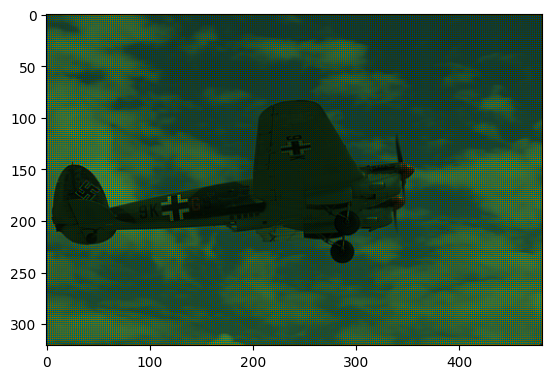

5.7583857
34.636627


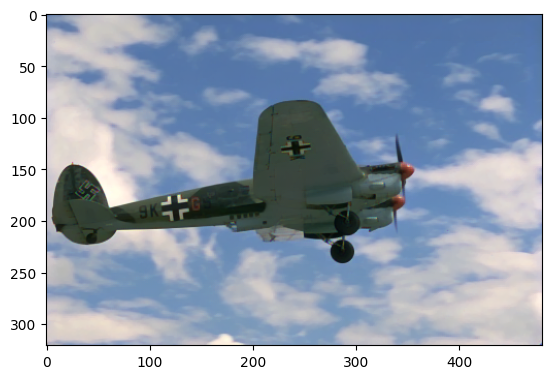

In [8]:
plt.imshow(x_baseline)
plt.show()
plt.imshow(res)

print(metric.psnr(x, x_baseline))
print(metric.psnr(x, res))